In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Image Processing with Neural Network
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_labels

2024-05-11 16:38:29.804435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 16:38:29.804473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 16:38:29.805355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 16:38:29.810471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 16:38:30.444125: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'students_base_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 190
IMG_WIDTH = 190

# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1) 
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print (physical_devices)
else:
    print ('Error: No GPU device found')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-11 16:38:31.761684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 16:38:31.796126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 16:38:31.796418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Helper Functions
**Note** all helper functions have been moved to util.helper

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [5]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [6]:
data_dir

'../../input/flower_photos'

In [7]:
# list content of data_dir
os.listdir(data_dir)

['tulips', 'daisy', 'sunflowers', 'LICENSE.txt', 'roses', 'dandelion']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-05-11 16:38:31.935821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 16:38:31.936096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 16:38:31.936283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


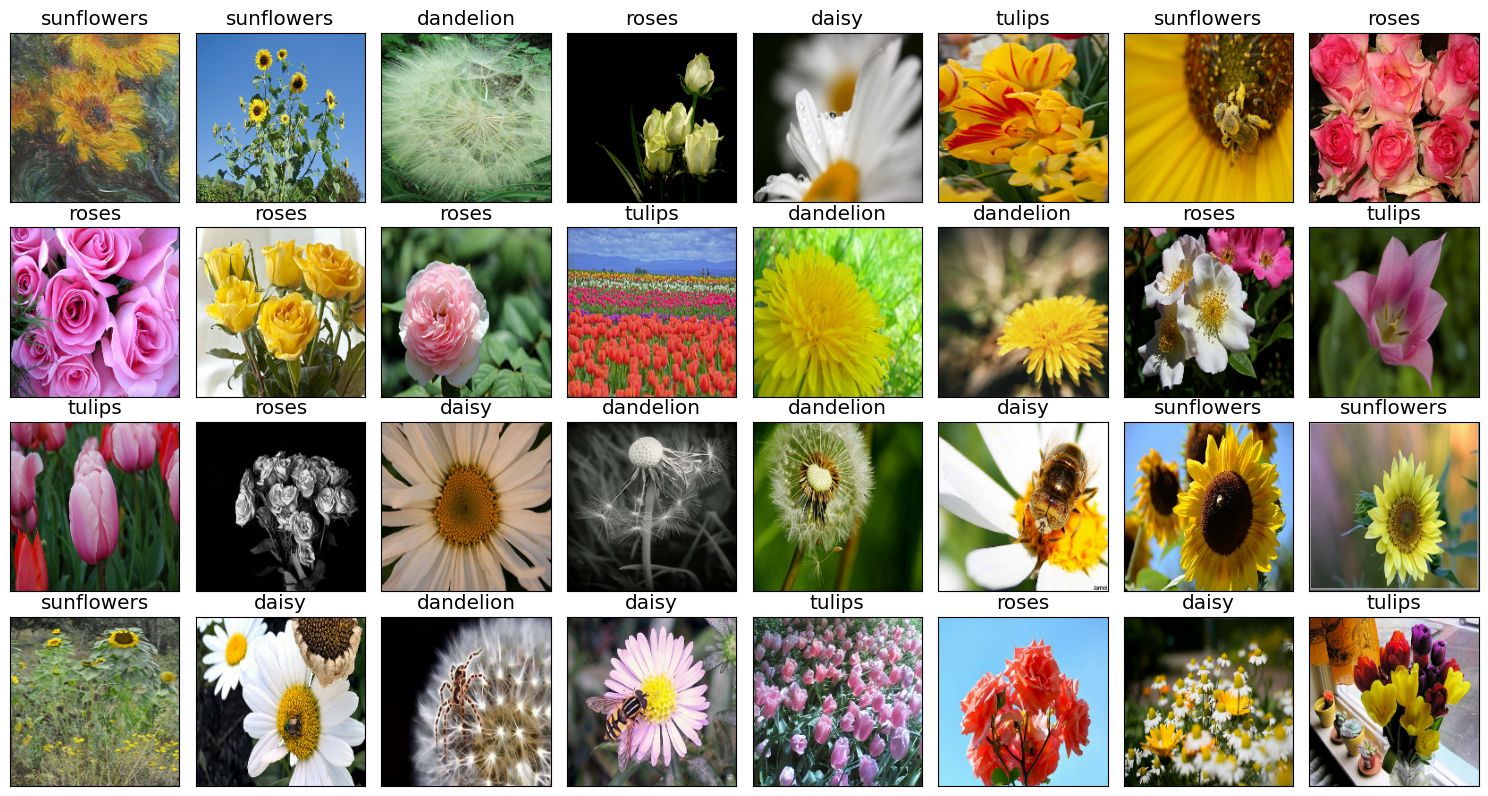

In [10]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

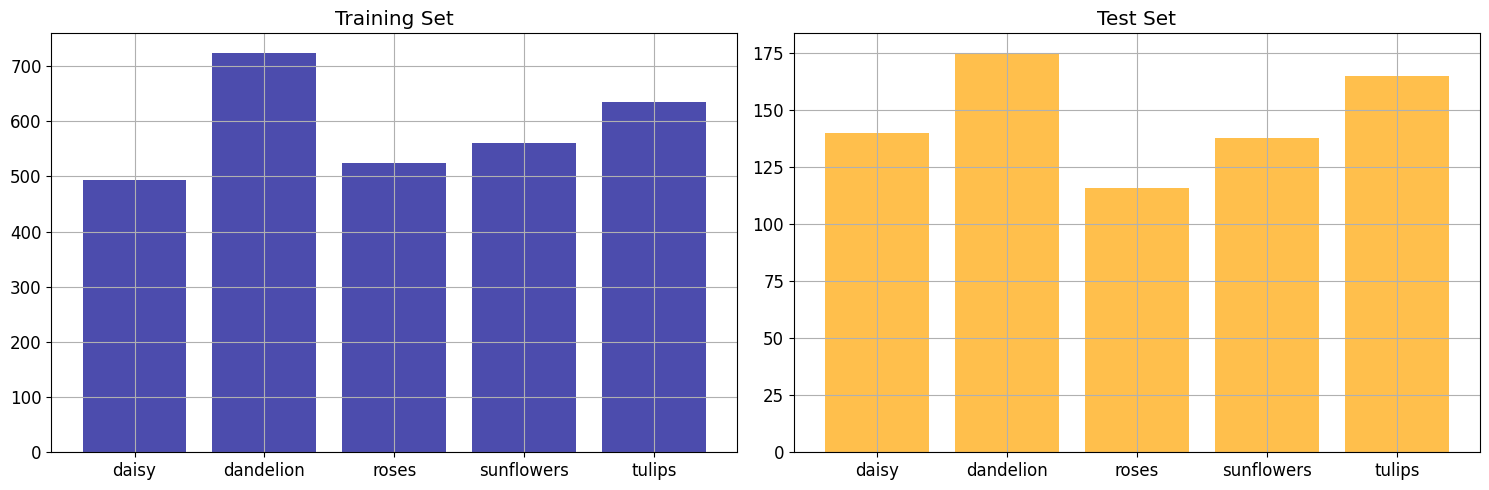

In [12]:
# how many examples in each of the class
fn_plot_labels(train_ds, test_ds)

In [13]:
def build_model(input_shape, num_classes):
    

    ###-----------------------
    ### Define your model here
    ###-----------------------
    
    return model

### Reload best Weights for evaluation

### Evaluate the model

## Validate on the validation set

In [ ]:
data_dir = os.path.join(inpDir, valDir)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    #subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots
i = 0
# take one batch of the dataset
for images, labels in valid_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

In [ ]:
loss, acc = new_model.evaluate(valid_ds)

print('Accuracy score on Validation Data : {:.3f}%'.format( acc*100))

In [ ]:
for images, labels in valid_ds.take(2 ):
    
    # Predict again to keep y_pred in synch with the images
    yhat = new_model.predict(images, verbose = 0)
    
    y_pred = yhat.argmax(axis = 1)
    fontsize = 12
    fig = plt.figure()  # figure with default size in inches
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

    for i in range ( BATCH_SIZE ):
        
        if labels.numpy()[i]!= y_pred[i]:
            fc = 'purple'
            ec="red"
            text_color = 'yellow'
        else:
            fc = 'cyan'
            ec = 'blue'
            text_color = 'blue'

        props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec = ec)
        
        ax = fig.add_subplot(BATCH_SIZE // 8 , 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        ax.imshow ( images[i].numpy().astype( "uint8" ) )
        
        ax.text(0.1, 0.95, class_names[y_pred[i]], transform=ax.transAxes, 
                fontsize=fontsize, color = text_color,
            verticalalignment='top', bbox=props)   # add number (class) of the image

        
        ax.set_title(class_names[labels.numpy()[i]])
        #ax.set_title('{} \n {}'.format( class_names[labels.numpy()[i]], ))
        
        ax.axis("off")
        
    plt.tight_layout()
    
    plt.show()